In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
'''data = np.load('arrays_lc.npz')

new_data = {}

# Iterate over each array in the original .npz file
for key in data.files:
    # Extract the (64, 64) slice corresponding to slice (64,64,0)
    slice_ = data[key][:,:,0]
    
    # Add the slice to the new_data dictionary
    new_data[key] = slice_

# Save the new slices in a new .npz file
np.savez('arrays_lc_2D.npz', **new_data)'''

"data = np.load('arrays_lc.npz')\n\nnew_data = {}\n\n# Iterate over each array in the original .npz file\nfor key in data.files:\n    # Extract the (64, 64) slice corresponding to slice (64,64,0)\n    slice_ = data[key][:,:,0]\n    \n    # Add the slice to the new_data dictionary\n    new_data[key] = slice_\n\n# Save the new slices in a new .npz file\nnp.savez('arrays_lc_2D.npz', **new_data)"

<class 'numpy.float32'>


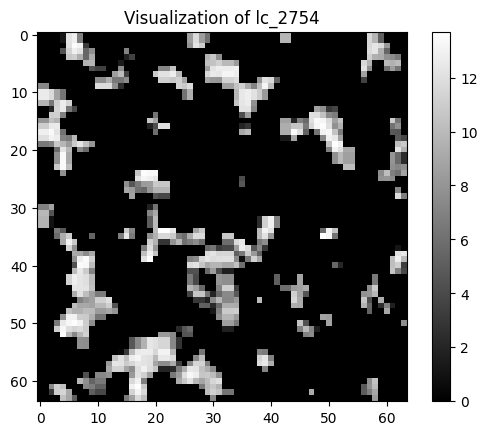

In [3]:
data = np.load('arrays_lc_2D.npz')

# Extract one array by its key. For example, using 'lc_2754'
# Assuming 'lc_2754' is the key for one of the arrays
array = data['lc_2754']
print(type(array[0,0]))

# Visualize the array using matplotlib
plt.imshow(array, cmap='gray')  # 'cmap' sets the color map. 'gray' is commonly used for single-channel images
plt.colorbar()  # Optionally add a colorbar to indicate the scale
plt.title('Visualization of lc_2754')
plt.show()

In [4]:
# Initialize a list to hold the noisy versions of the current array
input_data = []
labels = []
labels_binary = []

for i, key in enumerate(data.files[::10]):
    # Access the array
    original_array = data[key]/1000


    # Generate 100 versions with random Gaussian noise added
    for _ in range(100):
        # Generate random Gaussian noise with mean=0 and std=1
        # Note: You can adjust the mean and std according to your needs
        noise = np.random.normal(0, 0.0125, original_array.shape)
        if i == 0:
            print(np.max(noise))
        
        # Add the noise to the original array
        noisy_array = original_array + noise

        min_val_combined = noisy_array.min()
        max_val_combined = noisy_array.max()
        normalized_combined_array = (noisy_array - min_val_combined) / (max_val_combined - min_val_combined)

        normalized_label = (original_array - min_val_combined) / (max_val_combined - min_val_combined)
        asd = (original_array - min_val_combined) / (max_val_combined - min_val_combined)

        threshold = (np.max(normalized_label) + np.min(normalized_label))/2 - 0.05*(np.max(normalized_label))
        normalized_label[normalized_label >= threshold] = 1.0
        normalized_label[normalized_label < threshold] = 0.0
        
        # Append the noisy version to the list
        input_data.append(normalized_combined_array)
        labels.append(asd)
        labels_binary.append(normalized_label)

0.04423785307267844
0.046487795673418625
0.04501468193846956
0.040281055970997404
0.042762077252267584
0.041907237286742276
0.04201016714151912
0.043657574141224814
0.04480551703266742
0.04171151963337329
0.04525455213128501
0.04559471249630451
0.04157438512131057
0.04184171461250649
0.0441430127959731
0.042765781898925374
0.042096234955184775
0.04264021298210574
0.04788902759616067
0.047846675947300576
0.04399578108956896
0.04257006486624837
0.04400392356408461
0.04349508716641333
0.03804553605566824
0.04338779154188746
0.05210431108658229
0.047183691770432634
0.043012008833857855
0.049133036339662824
0.04975901708166794
0.04619024900542811
0.04434655630894551
0.040385950509176524
0.04801006636323727
0.04379377093533687
0.04643039313181981
0.04447155247029017
0.046759327592218784
0.05144183306898399
0.041969422569345334
0.043545729034201536
0.05045360718962253
0.042183932798113694
0.048048718872312574
0.042177410401822955
0.04244859249068421
0.05267402702016352
0.03970565172743203
0.0

In [5]:
np.shape(input_data[0])

(64, 64)

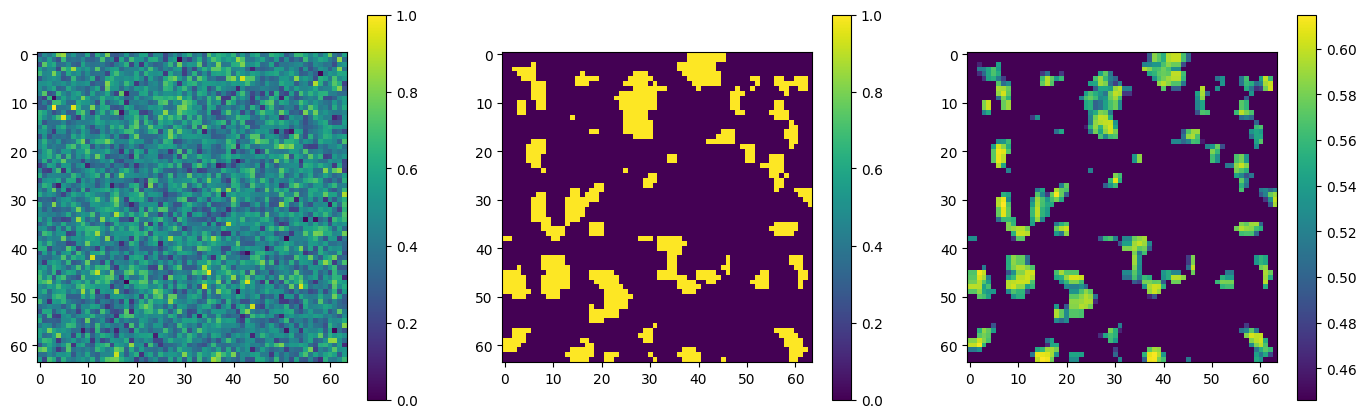

In [6]:
i = 0

plt.figure(figsize=(17,5))
plt.subplot(131)
plt.imshow(input_data[i])
plt.colorbar()
plt.subplot(132)
plt.imshow(labels_binary[i])
plt.colorbar()
plt.subplot(133)
plt.imshow(labels[i])
plt.colorbar()

In [7]:
len(input_data) == len(labels_binary)

True

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((input_data, labels_binary))

In [9]:
len(dataset)

100100

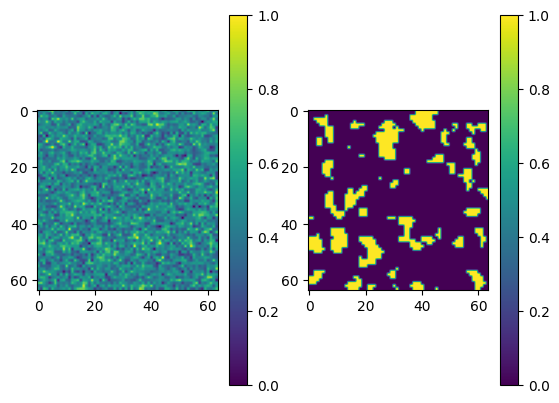

In [10]:
x, y = dataset.take(1).as_numpy_iterator().next()

plt.figure()
plt.subplot(121)
plt.imshow(x)
plt.colorbar()
plt.subplot(122)
plt.imshow(y)
plt.colorbar()
plt.show()


In [11]:
total_items = len(dataset)
train_size = int(0.9 * total_items)
val_size = int(0.095 * total_items)
test_size = total_items - train_size - val_size

print(train_size)
print(val_size)
print(test_size)

dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))

train_dataset = dataset_shuffled.take(train_size).batch(32)
val_dataset = dataset_shuffled.skip(train_size).take(val_size).batch(32)
test_dataset = dataset_shuffled.skip(train_size).skip(val_size).batch(32)

90090
9509
501


In [12]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Input, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau




def decoder_block(input_tensor, skip_features, n_filters, kernel_size=(3,3), batch_norm=True):
    # Transposed convolution (upsampling)
    x = Conv2DTranspose(n_filters, kernel_size, strides=(2, 2), padding='same')(input_tensor)
    # Concatenate with the corresponding output of the encoder (skip connection)
    x = concatenate([x, skip_features])
    # Convolutional layers with batch normalization and activation
    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def build_unet(input_shape=(64, 64, 1), n_filters=16, batch_norm=True):
    inputs = Input(input_shape)

    # Encoder: contracting path
    c1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(n_filters*12, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(n_filters*12, (3, 3), activation='relu', padding='same')(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    c6 = Conv2D(n_filters*16, (3, 3), activation='relu', padding='same')(p5)
    c6 = Conv2D(n_filters*16, (3, 3), activation='relu', padding='same')(c6)

    # Decoder: expansive path
    d7 = decoder_block(c6, c5, n_filters*12, batch_norm=batch_norm)
    d8 = decoder_block(d7, c4, n_filters*8, batch_norm=batch_norm)
    d9 = decoder_block(d8, c3, n_filters*4, batch_norm=batch_norm)
    d10 = decoder_block(d9, c2, n_filters*2, batch_norm=batch_norm)
    d11 = decoder_block(d10, c1, n_filters, batch_norm=batch_norm)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d11)

    # Model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build U-Net model
unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
callbacks = [
    ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1, mode='min', min_lr=1e-6)
]

history = unet_model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/3
 137/2816 [>.............................] - ETA: 22:05 - loss: 0.4393 - accuracy: 0.8198

KeyboardInterrupt: 